In [24]:
import numpy as np
import pandas as pd
import json
from sklearn import model_selection
import string
from math import log
from copy import deepcopy
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt
#Initializing Stop words
stop_words = set(stopwords.words("english"))

### Initializing valid set of Categories

In [25]:
#Set of valid categories : 
#Business, Comedy, Sports, Crime, Religion, Healthy Living, Politics.
category_dict={'business':0,'comedy':0,'sports':0,'crime':0,'religion':0,'healthy living':0,'politics':0}

In [26]:
#news_category_dataset.json
df=pd.read_json('news_category_dataset.json',lines=True)

In [27]:
df.head()

,short_description,headline,date,link,authors,category
0,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,2018-05-26,https://www.huffingtonpost.com/entry/texas-ama...,Melissa Jeltsen,CRIME
1,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,2018-05-26,https://www.huffingtonpost.com/entry/will-smit...,Andy McDonald,ENTERTAINMENT
2,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age 57,2018-05-26,https://www.huffingtonpost.com/entry/hugh-gran...,Ron Dicker,ENTERTAINMENT
3,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,2018-05-26,https://www.huffingtonpost.com/entry/jim-carre...,Ron Dicker,ENTERTAINMENT
4,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...,2018-05-26,https://www.huffingtonpost.com/entry/julianna-...,Ron Dicker,ENTERTAINMENT


In [28]:
df=df.loc[:, ['headline', 'category']]
df.head()

,headline,category
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


In [29]:
#Extracting data in the valid set of categories
df=df[df['category'].str.lower().isin(category_dict.keys())]
df.head()

,headline,category
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
13,Trump's Crackdown On Immigrant Parents Puts Mo...,POLITICS
14,'Trump's Son Should Be Concerned': FBI Obtaine...,POLITICS
15,Edward Snowden: There's No One Trump Loves Mor...,POLITICS
16,Booyah: Obama Photographer Hilariously Trolls ...,POLITICS


In [30]:
df.shape

(57274, 2)

### Test - Train Split

In [31]:
#Independent Variable
X=df['headline'].to_numpy()
#Dependent Variable
Y=df['category'].to_numpy()
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.15, random_state=0)
print(X_train.shape[0])

48682


In [32]:
print(Y_test.shape[0])

8592


### Multinomial Naive Bayes Classifier

In [33]:
class NB_Multinomial:
    
    def __init__(self):
        #Stores the Vocabulary and class wise doc count for each word
        self.word_class_dict={}
        self.prior=deepcopy(category_dict)
        self.cond_probablity={}
        #Calculates number of words per class
        self.class_words=deepcopy(category_dict)
        
    def preprocess(self,X,Y):
        global category_dict
        word_count={}
        #Creating the Word Class Dictionary
        for i in range(len(X)):
            _category=Y[i].lower()
            #Removing Punctuation and Converting to lower case
            temp_str=X[i].translate(str.maketrans('', '', string.punctuation)).lower()
            word_tokens = temp_str.split(' ')
            #Removing stopwords and adding to vocabulary
            for w in word_tokens:
                if w not in stop_words and len(w)>1:
                    #Counting Word Frequency
                    if w not in word_count.keys():
                        word_count[w]=0
                    else:
                        word_count[w]+=1
                        
                    word_in_dict=w in self.word_class_dict.keys()
                    if not word_in_dict:
                        self.word_class_dict[w]=deepcopy(category_dict)
                        self.word_class_dict[w][_category]+=1
                        self.class_words[_category]+=1
                    elif word_in_dict:
                        self.word_class_dict[w][_category]+=1
                        self.class_words[_category]+=1
        
        #Building Vocabulary
        for w in word_count.keys():
            if word_count[w]<2:
                #Deleting word not elligible to be present in dictionary
                del self.word_class_dict[w]
        
    def convert_to_lower(self,Y):
        total_len=len(Y)
        target=[]
        for i in range(total_len):
            target.append(Y[i].lower())
        return target
    
    def multinomial_probability(self,X,Y):
        global category_dict
        #Calculating Prior Probablity Values
        total_docs=len(Y)
        #Converting Y to lower case
        target=self.convert_to_lower(Y)
        docs_in_class=deepcopy(category_dict)
        
        #No. of headlines(documents) in each category
        for cat in target:
            docs_in_class[cat]+=1
        
        total_vocab_size=len(self.word_class_dict.keys())
        #Calculating Prior probability for each category
        for category in self.prior.keys():
            self.prior[category]=docs_in_class[category]/total_docs
        #Calculating Conditional Probablity for each category
        for w in self.word_class_dict.keys():
            self.cond_probablity[w]=deepcopy(category_dict)
            for category in self.cond_probablity[w].keys():
                self.cond_probablity[w][category]=(self.word_class_dict[w][category]+1)/(self.class_words[category]+total_vocab_size)
        
    
    def fit_transform(self,X,Y):
        self.preprocess(X,Y)
        self.multinomial_probability(X,Y)
    
    def extract_terms(self,D):
        vocab=[]
        #Removing punctuation and converting to lower case
        temp_str=D.translate(str.maketrans('', '', string.punctuation)).lower()
        word_tokens = temp_str.split(' ')
        #Removing Stop Words
        for w in word_tokens:
            if w not in stop_words and len(w)>1:
                vocab.append(w)
        
        return vocab
    
    def predict(self,X):
        global category_dict
        Y_pred=[]
        total_vocab_size=len(self.word_class_dict.keys())
        for i in range(len(X)):
            class_score=deepcopy(category_dict)
            #Extracting vocabulary for every (headline)document
            doc_vocab=self.extract_terms(X[i])
            for category in class_score.keys():
                class_score[category]=log(self.prior[category])
                for w in doc_vocab:
                    if w in self.word_class_dict.keys():
                        class_score[category]+=log(self.cond_probablity[w][category])
                    else:
                        #Conditional Probablity for a word not present in trained vocabulary
                        class_score[category]+=log(1/(self.class_words[category]+total_vocab_size))
            #Finding the category having maximum score
            predicted_category=max(class_score, key=class_score.get)
            Y_pred.append(predicted_category.upper())
        
        return Y_pred
    
    def accuracy_score(self,Y_pred,Y_test):
        target_pred=Y_pred
        target_test=Y_test
        count=0
        for i in range(len(target_pred)):
            if target_pred[i]==target_test[i]:
                count+=1
        acc_score=count/len(target_pred)
        print("Accuracy of the model is %s%%"%(round(acc_score*100,2)))
        

### Creating Classifier Model and Training 

In [34]:
model=NB_Multinomial()
start_time=time.time()
model.fit_transform(X_train,Y_train)
time_to_train=time.time()-start_time

### Model Training and Preprocessing Time

In [35]:
print("Time taken to train and preprocess model is : %s seconds "%(round(time_to_train,2)))

Time taken to train and preprocess model is : 1.54 seconds 


In [36]:
Y_pred=model.predict(X_test)

### Overall Test Accuracy of Model 

In [37]:
model.accuracy_score(Y_pred,Y_test)

Accuracy of the model is 78.55%


In [38]:
print(classification_report(Y_pred, Y_test))

                precision    recall  f1-score   support

      BUSINESS       0.56      0.62      0.59       570
        COMEDY       0.64      0.59      0.61       623
         CRIME       0.85      0.59      0.70       617
HEALTHY LIVING       0.78      0.68      0.73      1204
      POLITICS       0.84      0.90      0.87      4525
      RELIGION       0.62      0.58      0.60       434
        SPORTS       0.79      0.81      0.80       619

      accuracy                           0.79      8592
     macro avg       0.73      0.68      0.70      8592
  weighted avg       0.79      0.79      0.78      8592



### Confusion Matrix

In [39]:
category_list=list(category_dict.keys())
category_list=[x.upper() for x in category_list]
cm = confusion_matrix(Y_test, Y_pred,labels=category_list)
print(cm)

[[ 355    8    9   14   14  125  109]
 [  10  366   22   17   23   56   81]
 [  10   20  499   30    7   23   39]
 [   2    5    9  364    7    9   30]
 [  10   15   10   18  253   35   64]
 [  38   23   10   19   25  820  110]
 [ 145  186   60  155  105  136 4092]]


### Class Wise Accuracies

In [40]:
#Normalizing the diagonal entries
cm_norm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_accuracy=cm_norm.diagonal()*100
print("------------Class Wise Accuracies------------\n")
for i in range(len(category_list)):
    print(category_list[i]+" Accuracy = %s%% "%(round(class_accuracy[i],2)))

------------Class Wise Accuracies------------

BUSINESS Accuracy = 55.99% 
COMEDY Accuracy = 63.65% 
SPORTS Accuracy = 79.46% 
CRIME Accuracy = 85.45% 
RELIGION Accuracy = 62.47% 
HEALTHY LIVING Accuracy = 78.47% 
POLITICS Accuracy = 83.87% 


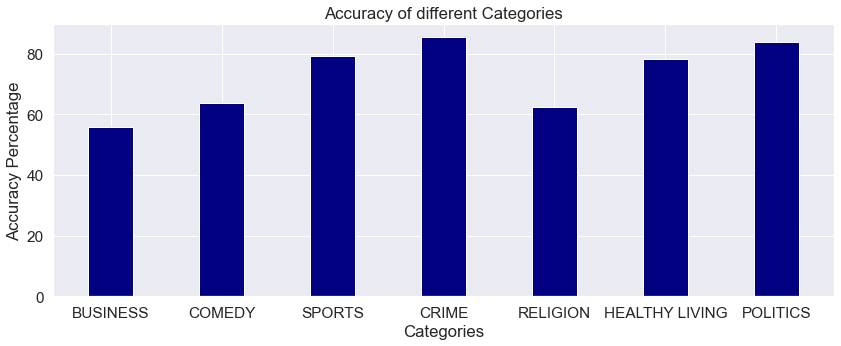

In [41]:
fig = plt.figure(figsize = (14, 5)) 
# creating the bar plot 
class_accuracy=[round(x,2) for x in class_accuracy]
plt.bar(category_list, class_accuracy, color ='navy',  
        width = 0.4) 
  
plt.xlabel("Categories") 
plt.ylabel("Accuracy Percentage") 
plt.title("Accuracy of different Categories") 
plt.show() 

### Confusion Matrix with Category labels

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

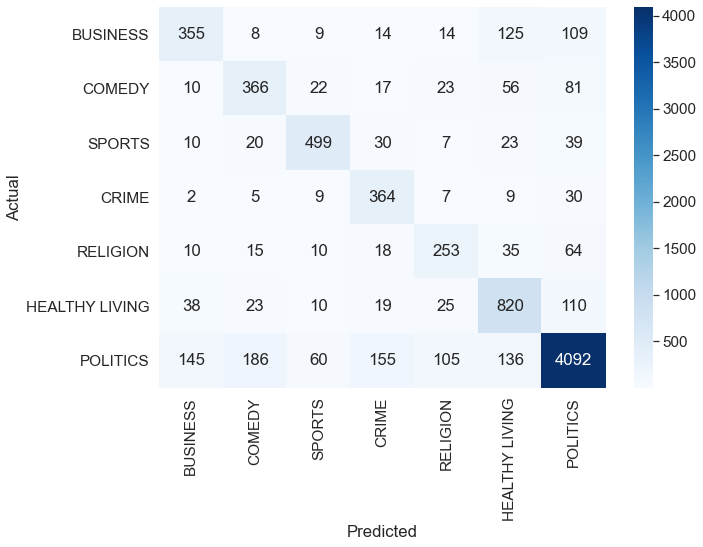

In [42]:
df_cm= pd.DataFrame(
    cm, 
    index=category_list, 
    columns=category_list
)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='d')